In [1]:
# imports
import numpy as np
import pandas as pd
import requests
import logging
import pickle

# finance
import yfinance as yf
#import pandas_ta as ta
import talib as ta

# visualisation
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# time
import time
from datetime import date, datetime, timedelta

# maschine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score


# 0. Getting Data

In [ ]:
def get_coins():
        # set up logging to display info and error messages
        logging.basicConfig(
            level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # list of coins
        coins = [
             #biggest coins
            "BTCUSDT",
            "ETHUSDT",
            "BNBUSDT",
            "SOLUSDT",
            "DOGEUSDT",
            #stablecoin
            "USDCUSDT"
        ]

        def fetch_crypto_ohlc(coin, interval="1h", start_str="1 Aug, 2024"):
            url = "https://api.binance.com/api/v1/klines"

            # convert start date string to datetime object
            start_time = pd.to_datetime(start_str)
            end_time = datetime.now()

            all_data = []

            while start_time < end_time:
                # define request parameters for binance api
                params = {
                    "symbol": coin,
                    "interval": interval,
                    "startTime": int(start_time.timestamp() * 1000),
                    "endTime": int(
                        (start_time + timedelta(days=30)).timestamp() * 1000
                    ),  # fetching 30 days at a time
                }

                response = requests.get(url, params=params)

                # check if request was successful
                if response.status_code != 200:
                    logging.error(f"Error fetching data for {coin}: {response.status_code}")
                    break

                data = response.json()

                # check if data is returned
                if not data:
                    logging.warning(f"No OHLC data found for {coin}.")
                    break

                all_data.extend(data)

                # update start time for next request
                start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                    milliseconds=1
                )

                logging.info(f"Fetched data for {coin} up to {start_time}")
                time.sleep(0.5)  # pause to avoid api limits

            if not all_data:
                return pd.DataFrame()

            # convert data into df with appropriate column names
            ohlc_df = pd.DataFrame(
                all_data,
                columns=[
                    "timestamp",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "close_time",
                    "quote_asset_volume",
                    "number_of_trades",
                    "taker_buy_base_asset_volume",
                    "taker_buy_quote_asset_volume",
                    "ignore",
                ],
            )

            # columns
            stablecoins = [ "USDCUSDT"]
            ohlc_df["ticker"] = coin
            ohlc_df["ticker_type"] = "stablecoin" if coin in stablecoins else "cryptocurrency"
            ohlc_df['ticker_type'] = ohlc_df['ticker_type'].astype('category')

            # convert price and volume to float
            ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[["open", "high", "low", "close", "volume"]].astype(float)
            ohlc_df["price_change"] = (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100

            # setting the timezone to Berlin
            ohlc_df["date"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
            ohlc_df["date"] = (
                ohlc_df["date"].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
            )
            ohlc_df.set_index("date", inplace=True)

            return ohlc_df[
                [
                    "ticker",
                    "ticker_type",
                    "open",
                    "high",
                    "low",
                    "close",
                    "price_change",
                    "volume"
                ]
            ]

        def generate_datetime_features(df):
            # generate additional datetime features
            df["year"] = df.index.year.astype(int)
            df["month"] = df.index.month.astype(int)
            df["day"] = df.index.weekday.astype(int)
            df["hour"] = df.index.hour.astype(int)

            return df

        # main script
        all_data = pd.DataFrame()

        for coin in coins:
            logging.info(f"Fetching data for {coin}")
            df = fetch_crypto_ohlc(coin)

            if not df.empty:
                df = generate_datetime_features(df)
                all_data = pd.concat([all_data, df])
            else:
                logging.warning(f"No data fetched for {coin}")

        # reorder columns to have datetime features at the beginning
        datetime_features = ["year", "month", "day", "hour", "ticker", "ticker_type"]
        other_columns = [col for col in all_data.columns if col not in datetime_features]
        all_data = all_data[datetime_features + other_columns]

        all_data['ticker'] = all_data['ticker'].astype('category')

        # save df to csv
        all_data.to_csv('crypto.csv', index=True)
        logging.info("Data fetching and processing complete. Data saved to crypto.csv")

        all_data.info()

        all_data.describe()


if __name__ == "__main__":
        get_coins()

2024-11-20 17:40:25,531 - INFO - Fetching data for BTCUSDT
2024-11-20 17:40:26,015 - INFO - Fetched data for BTCUSDT up to 2024-08-21 19:00:00.001000
2024-11-20 17:40:26,936 - INFO - Fetched data for BTCUSDT up to 2024-09-11 15:00:00.001000
2024-11-20 17:40:27,859 - INFO - Fetched data for BTCUSDT up to 2024-10-02 11:00:00.001000
2024-11-20 17:40:29,387 - INFO - Fetched data for BTCUSDT up to 2024-10-23 07:00:00.001000
2024-11-20 17:40:30,319 - INFO - Fetched data for BTCUSDT up to 2024-11-13 03:00:00.001000
2024-11-20 17:40:31,238 - INFO - Fetched data for BTCUSDT up to 2024-11-20 16:00:00.001000
2024-11-20 17:40:32,075 - WARNING - No OHLC data found for BTCUSDT.
2024-11-20 17:40:32,128 - INFO - Fetching data for ETHUSDT
2024-11-20 17:40:32,457 - INFO - Fetched data for ETHUSDT up to 2024-08-21 19:00:00.001000
2024-11-20 17:40:33,388 - INFO - Fetched data for ETHUSDT up to 2024-09-11 15:00:00.001000
2024-11-20 17:40:34,311 - INFO - Fetched data for ETHUSDT up to 2024-10-02 11:00:00.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16086 entries, 2024-08-01 02:00:00+02:00 to 2024-11-20 17:00:00+01:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          16086 non-null  int64   
 1   month         16086 non-null  int64   
 2   day           16086 non-null  int64   
 3   hour          16086 non-null  int64   
 4   ticker        16086 non-null  category
 5   ticker_type   16086 non-null  object  
 6   open          16086 non-null  float64 
 7   high          16086 non-null  float64 
 8   low           16086 non-null  float64 
 9   close         16086 non-null  float64 
 10  price_change  16086 non-null  float64 
 11  volume        16086 non-null  float64 
dtypes: category(1), float64(6), int64(4), object(1)
memory usage: 1.5+ MB


Fetching data for AAL...
Data for AAL successfully fetched.
Fetching data for AAPL...
Data for AAPL successfully fetched.
Fetching data for ABEV...
Data for ABEV successfully fetched.
Fetching data for ABT...
Data for ABT successfully fetched.
Fetching data for ADBE...
Data for ADBE successfully fetched.
Fetching data for ADS...


2024-11-20 17:41:04,124 - ERROR - $ADS: possibly delisted; no timezone found


No data found for ADS. This might indicate it's delisted or has no data in this period.
Fetching data for AGNC...
Data for AGNC successfully fetched.
Fetching data for ALV...
Data for ALV successfully fetched.
Fetching data for AMD...
Data for AMD successfully fetched.
Fetching data for AMGN...
Data for AMGN successfully fetched.
Fetching data for AMZN...
Data for AMZN successfully fetched.
Fetching data for AVGO...
Data for AVGO successfully fetched.
Fetching data for BA...
Data for BA successfully fetched.
Fetching data for BAC...
Data for BAC successfully fetched.
Fetching data for BAK...
Data for BAK successfully fetched.
Fetching data for BAS...


2024-11-20 17:41:05,244 - ERROR - $BAS: possibly delisted; no timezone found
2024-11-20 17:41:05,411 - ERROR - $BEI: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


No data found for BAS. This might indicate it's delisted or has no data in this period.
Fetching data for BBD...
Data for BBD successfully fetched.
Fetching data for BEI...
No data found for BEI. This might indicate it's delisted or has no data in this period.
Fetching data for BHP...
Data for BHP successfully fetched.
Fetching data for BKKT...
Data for BKKT successfully fetched.
Fetching data for BLK...
Data for BLK successfully fetched.
Fetching data for BMW...


2024-11-20 17:41:05,775 - ERROR - $BMW: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


No data found for BMW. This might indicate it's delisted or has no data in this period.
Fetching data for BMY...
Data for BMY successfully fetched.
Fetching data for BP...
Data for BP successfully fetched.
Fetching data for BRK.B...


2024-11-20 17:41:06,874 - ERROR - $BRK.B: possibly delisted; no timezone found
2024-11-20 17:41:06,945 - ERROR - $BVB: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


No data found for BRK.B. This might indicate it's delisted or has no data in this period.
Fetching data for BVB...
No data found for BVB. This might indicate it's delisted or has no data in this period.
Fetching data for CAN...
Data for CAN successfully fetched.
Fetching data for CAT...
Data for CAT successfully fetched.
Fetching data for CCL...
Data for CCL successfully fetched.
Fetching data for CMCSA...
Data for CMCSA successfully fetched.
Fetching data for CME...
Data for CME successfully fetched.
Fetching data for CMG...
Data for CMG successfully fetched.
Fetching data for COIN...
Data for COIN successfully fetched.
Fetching data for COST...
Data for COST successfully fetched.
Fetching data for CRM...
Data for CRM successfully fetched.
Fetching data for CSCO...


2024-11-20 17:41:08,097 - ERROR - $DBK: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


Data for CSCO successfully fetched.
Fetching data for CVX...
Data for CVX successfully fetched.
Fetching data for DBK...
No data found for DBK. This might indicate it's delisted or has no data in this period.
Fetching data for DHR...
Data for DHR successfully fetched.
Fetching data for DIS...
Data for DIS successfully fetched.
Fetching data for DJT...
Data for DJT successfully fetched.
Fetching data for DOCN...
Data for DOCN successfully fetched.
Fetching data for DPW...


2024-11-20 17:41:09,503 - ERROR - $DPW: possibly delisted; no timezone found


No data found for DPW. This might indicate it's delisted or has no data in this period.
Fetching data for DTE...
Data for DTE successfully fetched.
Fetching data for EBON...
Data for EBON successfully fetched.
Fetching data for EON...


2024-11-20 17:41:09,769 - ERROR - $EON: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


No data found for EON. This might indicate it's delisted or has no data in this period.
Fetching data for ERIC...
Data for ERIC successfully fetched.
Fetching data for F...
Data for F successfully fetched.
Fetching data for FB...


2024-11-20 17:41:10,820 - ERROR - $FB: possibly delisted; no timezone found


No data found for FB. This might indicate it's delisted or has no data in this period.
Fetching data for FIDELITY...


2024-11-20 17:41:11,621 - ERROR - $FIDELITY: possibly delisted; no timezone found
2024-11-20 17:41:11,692 - ERROR - $FRE: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


No data found for FIDELITY. This might indicate it's delisted or has no data in this period.
Fetching data for FRE...
No data found for FRE. This might indicate it's delisted or has no data in this period.
Fetching data for GLD...
Data for GLD successfully fetched.
Fetching data for GLXY...


2024-11-20 17:41:12,541 - ERROR - $GLXY: possibly delisted; no timezone found


No data found for GLXY. This might indicate it's delisted or has no data in this period.
Fetching data for GOLD...
Data for GOLD successfully fetched.
Fetching data for GOOG...
Data for GOOG successfully fetched.
Fetching data for GOOGL...
Data for GOOGL successfully fetched.
Fetching data for GRAB...
Data for GRAB successfully fetched.
Fetching data for GS...
Data for GS successfully fetched.
Fetching data for HD...
Data for HD successfully fetched.
Fetching data for HEI...
Data for HEI successfully fetched.
Fetching data for HON...
Data for HON successfully fetched.
Fetching data for HUT...
Data for HUT successfully fetched.
Fetching data for IBM...
Data for IBM successfully fetched.
Fetching data for ICE...
Data for ICE successfully fetched.
Fetching data for INTC...
Data for INTC successfully fetched.
Fetching data for IONQ...
Data for IONQ successfully fetched.
Fetching data for JBLU...
Data for JBLU successfully fetched.
Fetching data for JNJ...
Data for JNJ successfully fetched.

2024-11-20 17:41:14,642 - ERROR - $KSV: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


Data for KGC successfully fetched.
Fetching data for KSV...
No data found for KSV. This might indicate it's delisted or has no data in this period.
Fetching data for LCID...
Data for LCID successfully fetched.
Fetching data for LHA...


2024-11-20 17:41:14,807 - ERROR - $LHA: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


No data found for LHA. This might indicate it's delisted or has no data in this period.
Fetching data for LIN...
Data for LIN successfully fetched.
Fetching data for LLY...
Data for LLY successfully fetched.
Fetching data for LMT...
Data for LMT successfully fetched.
Fetching data for MA...
Data for MA successfully fetched.
Fetching data for MARA...
Data for MARA successfully fetched.
Fetching data for MDT...
Data for MDT successfully fetched.
Fetching data for MRK...
Data for MRK successfully fetched.
Fetching data for MS...
Data for MS successfully fetched.
Fetching data for MSFT...
Data for MSFT successfully fetched.
Fetching data for MSTR...
Data for MSTR successfully fetched.
Fetching data for NDAQ...
Data for NDAQ successfully fetched.
Fetching data for NEM...
Data for NEM successfully fetched.
Fetching data for NFLX...
Data for NFLX successfully fetched.
Fetching data for NIO...
Data for NIO successfully fetched.
Fetching data for NKE...
Data for NKE successfully fetched.
Fetchi

2024-11-20 17:41:17,942 - ERROR - $RWE: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


Data for RIVN successfully fetched.
Fetching data for RWE...
No data found for RWE. This might indicate it's delisted or has no data in this period.
Fetching data for SAP...
Data for SAP successfully fetched.
Fetching data for SBUX...
Data for SBUX successfully fetched.
Fetching data for SI...


2024-11-20 17:41:18,894 - ERROR - $SI: possibly delisted; no timezone found
2024-11-20 17:41:19,027 - ERROR - $SIE: possibly delisted; no price data found  (1h 2024-09-21 -> 2024-11-20)


No data found for SI. This might indicate it's delisted or has no data in this period.
Fetching data for SIE...
No data found for SIE. This might indicate it's delisted or has no data in this period.
Fetching data for SMCI...
Data for SMCI successfully fetched.
Fetching data for SNAP...
Data for SNAP successfully fetched.
Fetching data for SOFI...
Data for SOFI successfully fetched.
Fetching data for SOUN...
Data for SOUN successfully fetched.
Fetching data for SPGI...
Data for SPGI successfully fetched.
Fetching data for SQ...
Data for SQ successfully fetched.
Fetching data for T...
Data for T successfully fetched.
Fetching data for TMO...
Data for TMO successfully fetched.
Fetching data for TSLA...
Data for TSLA successfully fetched.
Fetching data for TWLO...
Data for TWLO successfully fetched.
Fetching data for TXN...
Data for TXN successfully fetched.
Fetching data for UNH...
Data for UNH successfully fetched.
Fetching data for V...
Data for V successfully fetched.
Fetching data fo

2024-11-20 17:41:21,268 - ERROR - $VOW3: possibly delisted; no timezone found


No data found for VOW3. This might indicate it's delisted or has no data in this period.
Fetching data for VZ...
Data for VZ successfully fetched.
Fetching data for WMT...
Data for WMT successfully fetched.
Fetching data for WULF...
Data for WULF successfully fetched.
Fetching data for XOM...
Data for XOM successfully fetched.
Combined data saved.
Data extraction complete! Please check the logs for errors.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32163 entries, 2024-09-23 15:30:00+02:00 to 2024-11-19 21:30:00+01:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          32163 non-null  int64   
 1   month         32163 non-null  int64   
 2   day           32163 non-null  int64   
 3   hour          32163 non-null  int64   
 4   ticker        32163 non-null  category
 5   ticker_type   32163 non-null  category
 6   open          32163 non-null  float64 
 7   high          32163 non-null  flo

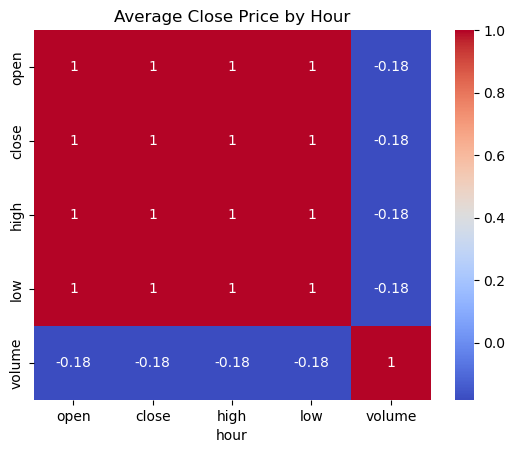

In [ ]:
# get stock data from api and transform it into df and csv
def get_stocks():
    # list of tickers
    snp500_tickers = [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'FB', 'TSLA', 'BRK.B', 'NVDA',
        'JPM', 'JNJ', 'V', 'PG', 'UNH', 'HD', 'MA', 'DIS', 'PYPL', 'VZ',
        'INTC', 'NFLX', 'CMCSA', 'PEP', 'T', 'CSCO', 'PFE', 'ADBE',
        'NKE', 'MRK', 'XOM', 'AVGO', 'ABT', 'CRM', 'TMO', 'AMD', 'LLY',
        'NKE', 'IBM', 'COST', 'LMT', 'WMT', 'MDT', 'CVX', 'HON',
        'TXN', 'NOW', 'QCOM', 'BMY', 'SBUX', 'DHR', 'AMGN', 'CAT'
    ]

    dax_tickers = [
        'ADS', 'ALV', 'BAK', 'BAS', 'BEI', 'BMW', 'BVB', 'DBK',
        'DPW', 'DTE', 'EON', 'FRE', 'HEI', 'LHA', 'LIN', 'MRK',
        'RWE', 'SAP', 'SIE', 'VOW3'
    ]

    important_stocks = [
        'AAL', 'ABEV', 'AGNC', 'AVGO', 'BAC', 'BA', 'BBD', 'BHP',
        'BKKT', 'BLK', 'BP', 'CAN', 'CCL', 'CMG', 'CME', 'COIN',
        'CRM', 'CVX', 'DOCN', 'DJT', 'EBON', 'ERIC', 'F', 'FIDELITY',
        'GLD', 'GLXY', 'GOLD', 'GOOG', 'GRAB', 'GS', 'HUT', 'ICE',
        'IONQ', 'JBLU', 'JOBY', 'KDP', 'KGC', 'KSV', 'LCID', 'MARA',
        'MS', 'MSFT', 'MSTR', 'NDAQ', 'NEM', 'NIO', 'NYCB', 'NU',
        'OKLO', 'PLTR', 'PAYX', 'PFE', 'RIOT', 'RIVN', 'SI', 'SNAP',
        'SOUN', 'SOFI', 'SMCI', 'SPGI', 'SQ', 'T', 'TWLO', 'VALE',
        'VFC', 'WULF', 'XOM'
    ]

    comb_stocks = snp500_tickers + dax_tickers + important_stocks
    # sorting and removing duplicates
    stocks = sorted(set(comb_stocks))

    # timeframe
    end_date = datetime.now()
    start_date = end_date - timedelta(days=60)
    interval = '1h'

    # list for saving data
    all_data = []

    # getting data
    for stock in stocks:
        print(f"Fetching data for {stock}...")
        try:
            ticker = yf.Ticker(stock)
            df = ticker.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval=interval)

            if df.empty:
                print(f"No data found for {stock}. This might indicate it's delisted or has no data in this period.")
            else:
                df['ticker'] = stock
                df = df.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'], errors='ignore')

                # timezone Europe/Berlin
                df.index = pd.to_datetime(df.index, utc=True).tz_convert("Europe/Berlin")
                df.index.name = 'date'

                df['year'] = df.index.year.astype(int)
                df['month'] = df.index.month.astype(int)
                df['day'] = df.index.day.astype(int)
                df['hour'] = df.index.hour.astype(int)
                all_data.append(df)
                print(f"Data for {stock} successfully fetched.")

        except Exception as e:
            print(f"An error occurred for {stock}: {e}")

    # combining into one df
    if all_data:
        combined_data = pd.concat(all_data)
        # all lower
        combined_data.columns = combined_data.columns.str.lower()
        # adding price change in percent, tickertype
        combined_data['price_change'] = (combined_data['close'] - combined_data['open']) / combined_data['open'] * 100
        combined_data['ticker_type'] = 'stock'
        combined_data['ticker_type'] = combined_data['ticker_type'].astype('category')
        combined_data['ticker'] = combined_data['ticker'].astype('category')

        # sorting
        column_order = ['year', 'month', 'day', 'hour', 'ticker', 'ticker_type', 'open', 'high', 'low', 'close', 'price_change', 'volume']
        combined_data = combined_data[column_order]

        # saving
        combined_data.to_csv('stocks_60d.csv', index=True)
        print("Combined data saved.")

        combined_data.head(12)


    else:
        print("No data to save.")

    print("Data extraction complete! Please check the logs for errors.")

    # eda

    combined_data.nunique()

    combined_data.info()

    combined_data.describe()

    combined_data.isna().sum()


    corr_matrix = combined_data[['open', 'close', 'high', 'low', 'volume']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

    combined_data.groupby('hour')['close'].mean().plot(kind='line', title='Average Close Price by Hour')


if __name__ == "__main__":
    get_stocks()

In [29]:
#combining them into one df
stocks_df = pd.read_csv('stocks.csv')
crypto_df = pd.read_csv('stable_coin.csv')

# concat
df = pd.concat([stocks_df, crypto_df], ignore_index=True)

# transform object to category
df['ticker'] = df['ticker'].astype('category')
df['ticker_type'] = df['ticker_type'].astype('category')

# 1. Feature Engeneering

In [31]:
# creating new columns
# moving averages
df['7d_ma'] = df['close'].rolling(window=7).mean()
df['30d_ma'] = df['close'].rolling(window=30).mean()

# volatility (standard deviation of 'close' over last 7 days)
df['7d_volatility'] = df['close'].rolling(window=7).std()

# intraday range
df['intraday_range'] = (df['high'] - df['low']) / df['low']

# lag features
df['close_lag_1'] = df['close'].shift(1)

# talib
def add_ta_indicators(df):
    # ensure columns have correct data types
    df["open"] = df["open"].astype("float64")
    df["high"] = df["high"].astype("float64")
    df["low"] = df["low"].astype("float64")
    df["close"] = df["close"].astype("float64")
    df["volume"] = df["volume"].astype("float64")

    # calculate various technical indicators using TA-Lib
    df['adx'] = ta.ADX(df['high'], df['low'], df['close'])
    df['aroon'] = ta.AROON(df['high'], df['low'])[0]  # AROON Up
    df['bop'] = ta.BOP(df['open'], df['high'], df['low'], df['close'])
    df['cci'] = ta.CCI(df['high'], df['low'], df['close'])
    df['cmo'] = ta.CMO(df['close'])
    df['macd'], df['macd_signal'], df['macd_hist'] = ta.MACD(df['close'])
    df['mom'] = ta.MOM(df['close'])
    df['ppo'] = ta.PPO(df['close'])
    df['roc'] = ta.ROC(df['close'])
    df['rsi'] = ta.RSI(df['close'])
    df['willr'] = ta.WILLR(df['high'], df['low'], df['close'])
    df['atr'] = ta.ATR(df['high'], df['low'], df['close'])
    df['trix'] = ta.TRIX(df['close'])
    df['kama'] = ta.KAMA(df['close'])

    return df

df = add_ta_indicators(df)


# custom calculations
def add_custom_calculations(df, group_by_col="ticker"):
        # growth calculations for different time periods
        for hours in [1, 4, 24, 48, 72, 168, 336, 720]:
            df[f"growth_{hours}h"] = (
                df.groupby(group_by_col, observed=True)["close"].shift(hours) / df["close"]
            )
            future_shifted = df.groupby(group_by_col, observed=True)["close"].shift(-hours)
            df[f"growth_future_{hours}h"] = future_shifted / df["close"]
            df[f"is_positive_growth_{hours}h_future"] = np.where(
                df[f"growth_future_{hours}h"] > 1, 1, 0
            )

        # fibonacci levels
        df["fibonacci_0"] = df["close"]
        df["fibonacci_23_6"] = df["high"] - (df["high"] - df["low"]) * 0.236
        df["fibonacci_38_2"] = df["high"] - (df["high"] - df["low"]) * 0.382
        df["fibonacci_50"] = df["high"] - (df["high"] - df["low"]) * 0.5
        df["fibonacci_61_8"] = df["high"] - (df["high"] - df["low"]) * 0.618
        df["fibonacci_100"] = df["low"]

        return df

df = add_custom_calculations(df)

# 2. EDA

In [34]:
# checking for nan all rows colums
nan_counts = df.isna().sum()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(nan_counts)


# 0 values per row
zero_counts = (df == 0).sum()
for column, count in zero_counts.items():
    print(f"0 valaues for {column}: {count}")

zero_day_tickers = df[df['day'] == 0]
print("Tickers with 0 values for 'day':")
print(zero_day_tickers[['ticker', 'day']])

# deleting rows where day is 0
df.drop(df[df['day'] == 0].index, inplace=True)

# printing datatypes
print(f"Data types: {df.dtypes}")

# getting overview of unique tickers
unique_tickers = df['ticker'].nunique()
print(f"Number of individuel ticker: {unique_tickers}")

for col in df.columns:
    print(col)
    print(df[col].nunique())
    print()

# overview stats
usdcusdt_data = df[df['ticker'] == 'USDCUSDT']

stats_summary = usdcusdt_data.describe()
print(stats_summary)

# number of data for 'close'
n = len(usdcusdt_data)
print(f"Number of data for USDCUSDT: {n}")

# Find max and min price change
max_price_change = usdcusdt_data['price_change'].max()
print("Max price change for USDC:", max_price_change)

#correlation for numericals
stablecoin_data = df[df['ticker_type'] == 'stablecoin']
cor_df_stablecoin = stablecoin_data[['price_change', 'close', 'volume', 'intraday_range', 'adx', 'growth_1h']]
correlation_matrix_stablecoin = cor_df_stablecoin.corr()
print(correlation_matrix_stablecoin)

date                                  0
year                                  0
month                                 0
day                                   0
hour                                  0
ticker                                0
ticker_type                           0
open                                  0
high                                  0
low                                   0
close                                 0
price_change                          0
volume                                0
7d_ma                                 6
30d_ma                               29
7d_volatility                         6
intraday_range                        0
close_lag_1                           1
adx                                  27
aroon                                14
bop                                   0
cci                                  13
cmo                                  14
macd                                 33
macd_signal                          33


In [36]:
# Correlation insights:
# 1. Strong negative correlation between price_change and growth_1h (-0.82):
#    - Indicates that short-term price changes negatively affect 1-hour growth, possibly due to volatility.
# 2. Weak correlation between price_change and other variables (close, volume, intraday_range):
#    - Suggests these features have minimal direct impact on short-term price changes for stablecoins.
# 3. Strong positive correlation between volume and intraday_range (0.76):
#    - Higher trading volume is associated with larger intraday price movements, even for stablecoins.
# 4. Moderate positive correlation between close and adx (0.28):
#    - Implies stronger price trends occur at higher close prices, though not a major factor.
# 5. Growth_1h shows negative correlation with most variables:
#    - High intraday activity and volume may hinder stablecoin growth within an hour.

## 2.1 Visualisation

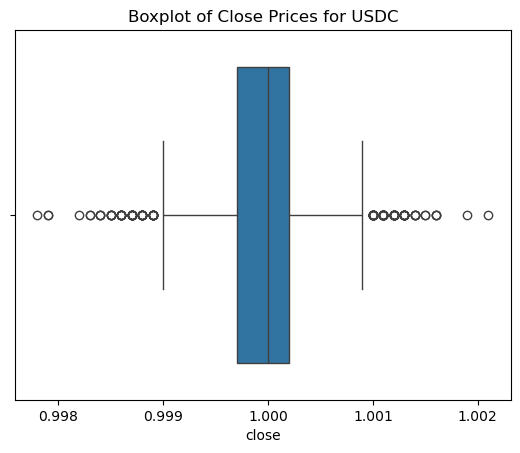

In [39]:
# boxplot
sns.boxplot(x=usdcusdt_data['close'])
plt.title('Boxplot of Close Prices for USDC')
plt.savefig('boxplot_usdc.png')
plt.show()

In [41]:
# Key Insights:
# **Stability of USDC**: The majority of the 'Close Prices' are very close to 1, indicating that USDC is functioning well as a stablecoin
# **Outlier Analysis**: There are outliers below 0.999 and above 1.001, which could be caused by short-term market movements or external events affecting its stability
# **Narrow Range**: The Interquartile Range (IQR) is extremely small, indicating that USDC is traded consistently with minimal fluctuations
# **Frequent Deviations**: The symmetrical outliers on both sides of 1 could indicate market mechanisms like arbitrage or liquidity movements

In [43]:
# looking closer at outliers
# Define thresholds for outliers
lower_threshold = 0.999
upper_threshold = 1.001

# Find outliers based on the close price
outliers = usdcusdt_data[(usdcusdt_data['close'] < lower_threshold) | (usdcusdt_data['close'] > upper_threshold)]

# Display outlier timestamps and corresponding close prices
outliers[['year','month', 'day', 'hour', 'close']]


,year,month,day,hour,close
44948,2024,8,3,22,1.0011
44974,2024,8,5,0,1.0011
44975,2024,8,5,1,1.0011
44976,2024,8,5,2,1.0012
44977,2024,8,5,3,1.0012
44978,2024,8,5,4,1.0013
44981,2024,8,5,7,1.0011
46618,2024,10,3,12,1.0012
46619,2024,10,3,13,1.0011
46620,2024,10,3,14,1.0011


In [45]:
# outliers occur mostly in clusters 
# outliers tend to happen in consecutive hours, suggesting possible market distortions or technical issues during specific periods 
# no clear pattern in terms of specific times, but frequent deviations 
# in early November could indicate heightened volatility or market stress, days around election  
# patterns hinting to external market events / liquidity shifts

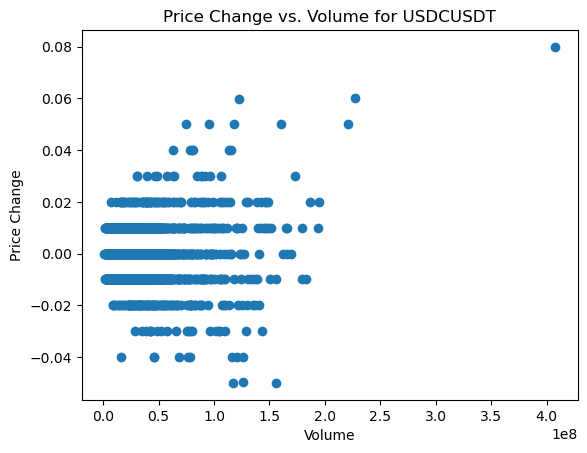

In [47]:
# does price change correlate with volume
plt.scatter(usdcusdt_data['volume'], usdcusdt_data['price_change'])
plt.title('Price Change vs. Volume for USDCUSDT')
plt.xlabel('Volume')
plt.ylabel('Price Change')
plt.savefig('price_change_correlation_with_volume.png')
plt.show()

In [ ]:
# The scatter plot shows the relationship between price change and trading volume for USDC/USDT.
# Most price changes are centered around 0, indicating stable behavior, even with varying volumes.
# There is a notable outlier with very high volume (~4e8) and a significant price change (~0.08).
# No clear linear correlation between volume and price change is observed, suggesting external factors 
# might influence price deviations more than volume alone.


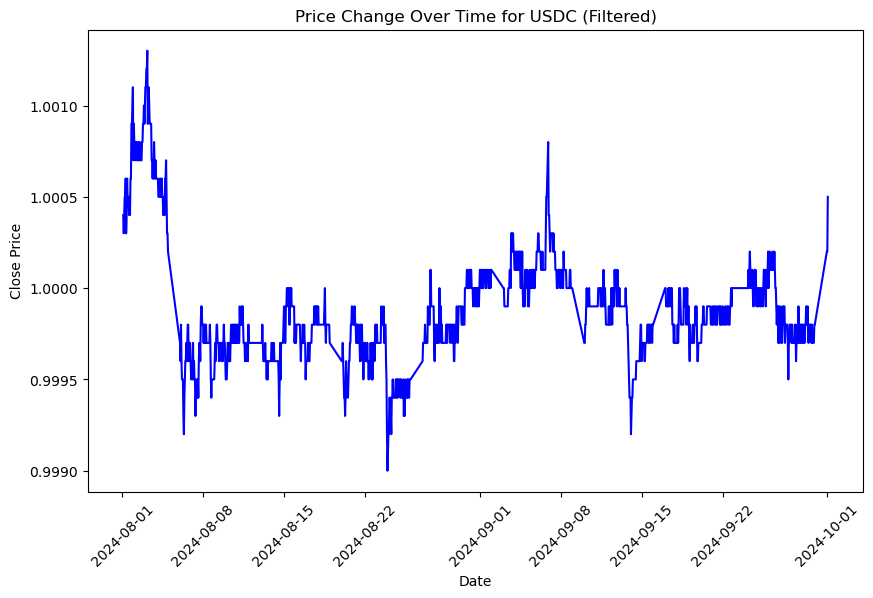

In [59]:
# filtering for tiemframe
start_date = pd.Timestamp('2024-08-01', tz='UTC')
end_date = pd.Timestamp('2024-10-01', tz='UTC')

usdcusdt_filtered = usdcusdt_data[(usdcusdt_data['date'] >= start_date) & (usdcusdt_data['date'] <= end_date)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(usdcusdt_filtered['date'], usdcusdt_filtered['close'], color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Price Change Over Time for USDC (Filtered)')
plt.xticks(rotation=45)
plt.savefig('price_change_over_time.png')
plt.show()

In [ ]:
# Key observations:
# - Price fluctuates slightly around the $1 mark, confirming USDC's stablecoin nature.
# - Periods of slight instability (e.g., price > $1.001 or < $0.999) may indicate unusual market activity or temporary imbalances.
# - Spikes at specific points (e.g., late August, mid-September) might be linked to external events or liquidity shifts.


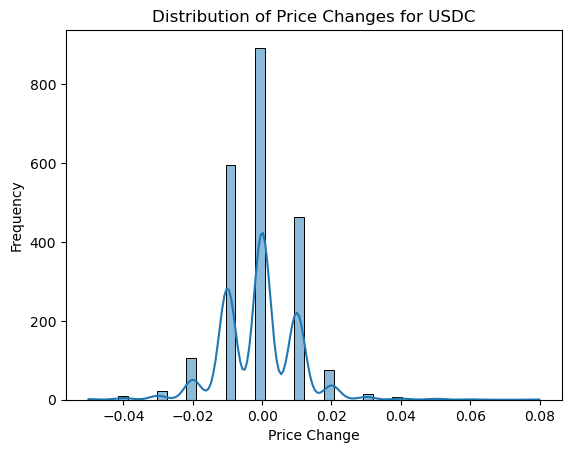

In [61]:
# histogram price_change for USDC
# calculating optimal bin
n = len(usdcusdt_data)
bins = int(np.sqrt(n))
sns.histplot(usdcusdt_data['price_change'], bins=bins, kde=True)
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Price Changes for USDC')
plt.savefig('distribution_price_change.png')
plt.show()

In [ ]:
# The histogram visualizes the distribution of price changes for USDC, a stablecoin.
# Key observations:
# - Most price changes are concentrated around 0, indicating that USDC's price remains stable, as expected for a stablecoin.
# - Distribution analysis:
#   1. Peak at 0: The high frequency of 0 price changes confirms minimal fluctuations for USDC in most cases.
#   2. Symmetric distribution: Price changes are evenly spread on both sides, showing that deviations (positive and negative) are rare and balanced.
#   3. Outliers: Smaller bars farther from 0 represent rare, larger price changes, which are atypical.
# - Implications:
#   - This validates USDC's stability, making it suitable as a reserve asset or a medium of exchange.
#   - The rare outliers might be caused by extreme market events or technical issues.


# 3. Maschine Learning

## 3.1 Preparation

In [13]:
# dropping date
if 'date' in df.columns:
    df.drop(columns=['date'], inplace=True)


df = df.fillna(df.select_dtypes(include=['number']).mean())

# new csv
df.to_csv('one_df.csv', index=False)

# splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# y  USDCUSDT
y_train = df_train['is_positive_growth_1h_future'].values
y_val = df_val['is_positive_growth_1h_future'].values
y_test = df_test['is_positive_growth_1h_future'].values

df_full_train = df_full_train.reset_index(drop=True)

df_full_train.close.value_counts(normalize=True)

df_full_train.close.mean()

# del what we want to predict
del df_train['is_positive_growth_1h_future']
del df_val['is_positive_growth_1h_future']
del df_test['is_positive_growth_1h_future']

In [14]:
numerical = ['open', 'high', 'low', 'volume', 'price_change', 'close',
             'growth_4h', 'growth_24h', 'growth_48h', 'growth_72h',
             'growth_168h', 'growth_336h', 'growth_720h']

categorical = ['year', 'month', 'day', 'hour', 'ticker', 'ticker_type']

technical = ['adx', 'aroon', 'bop', 'cci', 'cmo', 'macd', 'macd_signal', 'macd_hist',
            'mom', 'ppo', 'roc', 'rsi', 'willr', 'atr', 'trix', 'kama',
            '7d_ma', '30d_ma', '7d_volatility', 'intraday_range', 'fibonacci_0',
            'fibonacci_23_6', 'fibonacci_38_2', 'fibonacci_50', 'fibonacci_61_8',
            'fibonacci_100']

growth = ['growth_future_4h','is_positive_growth_24h_future', 'is_positive_growth_48h_future',
            'is_positive_growth_72h_future', 'is_positive_growth_168h_future',
            'is_positive_growth_336h_future', 'is_positive_growth_720h_future']

In [15]:
# defining features
X_train = df_train
X_val = df_val
X_test = df_test

# one hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical + technical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical + technical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# transforming test data
test_dict = df_test[categorical + numerical + technical].to_dict(orient='records')
X_test = dv.transform(test_dict)

## 3.2 Logistic Regression

In [37]:
# model
model_lr = LogisticRegression(class_weight='balanced', solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

# pred for validation set
y_pred_val_lr = model_lr.predict(X_val)

# evaluation
print(f"Logistic Regression Accuracy on Validation-Set: {accuracy_score(y_val, y_pred_val_lr)}")
print(f"Logistic Regression Confusion Matrix on Validation-Set:\n{confusion_matrix(y_val, y_pred_val_lr)}")
print(f"Logistic Regression Classification Report on Validation-Set:\n{classification_report(y_val, y_pred_val_lr)}")
print(f"Logistic Regression F1-Score on Validation-Set: {f1_score(y_val, y_pred_val_lr)}")
print(f"Logistic Regression ROC-AUC on Validation-Set: {roc_auc_score(y_val, model_lr.predict_proba(X_val)[:, 1])}")

# use model on test set and check results
y_pred_test = model_lr.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print(f"Accuracy on Test-Set: {accuracy_test}")
print(f"Confusion Matrix on Test-Set: \n{conf_matrix_test}")
print(f"Classification Report on Test-Set: \n{class_report_test}")


# original accuracy with all features
original_accuracy = accuracy_score(y_val, model_lr.predict(X_val))
print(f"Original Accuracy: {original_accuracy}")

# store results
feature_accuracies = {}
# store feature names
feature_names = dv.get_feature_names_out()

# loop through each feature
for feature_idx in range(X_train.shape[1]):
    # remove the current feature
    X_train_reduced = X_train[:, [i for i in range(X_train.shape[1]) if i != feature_idx]]
    X_val_reduced = X_val[:, [i for i in range(X_val.shape[1]) if i != feature_idx]]

    # train new model
    model_lr_reduced = LogisticRegression(class_weight='balanced', solver='liblinear',
                                          C=1.0, max_iter=1000, random_state=42)
    model_lr_reduced.fit(X_train_reduced, y_train)

    # evaluate new accuracy
    reduced_accuracy = accuracy_score(y_val, model_lr_reduced.predict(X_val_reduced))
    accuracy_difference = original_accuracy - reduced_accuracy

    # map index to feature name and store accuracy difference
    feature_accuracies[feature_names[feature_idx]] = accuracy_difference

# print results with feature names
for feature_name, acc_diff in feature_accuracies.items():
    print(f"Feature: {feature_name}, Accuracy Difference: {acc_diff:.4f}")

# extracting just the important features
important_features = [feature for feature, diff in feature_accuracies.items() if diff != 0.0]
print("Important Features:", important_features)

# new set with reduced data
X_train_reduced = X_train[:, [feature_names.tolist().index(feature) for feature in important_features]]
X_val_reduced = X_val[:, [feature_names.tolist().index(feature) for feature in important_features]]
X_test_reduced = X_test[:, [feature_names.tolist().index(feature) for feature in important_features]]

# new model
model_lr_reduced = LogisticRegression(class_weight='balanced', solver='liblinear',
                                      C=1.0, max_iter=1000, random_state=42)
model_lr_reduced.fit(X_train_reduced, y_train)

y_pred_val_reduced = model_lr_reduced.predict(X_val_reduced)

accuracy_val_reduced = accuracy_score(y_val, y_pred_val_reduced)
print(f"Accuracy on reduced Validation-Set: {accuracy_val_reduced}")
print(f"Confusion Matrix on reduced Validation-Set:\n{confusion_matrix(y_val, y_pred_val_reduced)}")
print(f"Classification Report on reduced Validation-Set:\n{classification_report(y_val, y_pred_val_reduced)}")

# check test data
y_pred_test_reduced = model_lr_reduced.predict(X_test_reduced)
accuracy_test_reduced = accuracy_score(y_test, y_pred_test_reduced)
print(f"Accuracy on Test-Set: {accuracy_test_reduced}")


Logistic Regression Accuracy on Validation-Set: 0.5099733333333333
Logistic Regression Confusion Matrix on Validation-Set:
[[3159 1666]
 [2928 1622]]
Logistic Regression Classification Report on Validation-Set:
              precision    recall  f1-score   support

           0       0.52      0.65      0.58      4825
           1       0.49      0.36      0.41      4550

    accuracy                           0.51      9375
   macro avg       0.51      0.51      0.50      9375
weighted avg       0.51      0.51      0.50      9375

Logistic Regression F1-Score on Validation-Set: 0.4138810921153355
Logistic Regression ROC-AUC on Validation-Set: 0.5175062574730969
Accuracy on Test-Set: 0.5173333333333333
Confusion Matrix on Test-Set: 
[[3163 1666]
 [2859 1687]]
Classification Report on Test-Set: 
              precision    recall  f1-score   support

           0       0.53      0.66      0.58      4829
           1       0.50      0.37      0.43      4546

    accuracy                  

## 3.3 Decision Tree

In [38]:
# lists for tuning parameters
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
sample_leafs = [1, 5, 10, 15, 20, 500, 100, 200]

# tuning max_depth
print("Tuning max_depth for Decision Tree:")
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42)
    dt.fit(X_train, y_train)

    # predicting for auc evaluation
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"max_depth = {depth} -> AUC: {auc:.3f}")

# tuning min_samples_leaf
print("\nTuning max_depth and min_samples_leaf for Decision Tree:")
scores = []

for depth in [4, 5, 6]:
    for s in sample_leafs:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, class_weight='balanced', random_state=42)
        dt.fit(X_train, y_train)

        # Predicting for AUC evaluation
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))

# convert results into df
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

# visualize tuning results
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='auc')
print("\nTuning Results:")
print(df_scores_pivot.round(3))

# select best model (with highest auc)
best_params = df_scores.loc[df_scores['auc'].idxmax()]
print("\nBest Hyperparameters:")
print(best_params)

# final model with best parameters
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model_dt.fit(X_train, y_train)

# predicting for the validation set
y_pred_val_dt = model_dt.predict(X_val)


# evaluation
print(f"Decision Tree Accuracy on the validation set: {accuracy_score(y_val, y_pred_val_dt)}")
print(f"Decision Tree Confusion Matrix on the validation set:\n{confusion_matrix(y_val, y_pred_val_dt)}")
print(f"Decision Tree Classification Report on the validation set:\n{classification_report(y_val, y_pred_val_dt)}")
print(f"Decision Tree F1-Score on the validation set: {f1_score(y_val, y_pred_val_dt)}")
print(f"Decision Tree ROC-AUC on the validation set: {roc_auc_score(y_val, model_dt.predict_proba(X_val)[:, 1])}")

Tuning max_depth for Decision Tree:
max_depth = 1 -> AUC: 0.514
max_depth = 2 -> AUC: 0.529
max_depth = 3 -> AUC: 0.532
max_depth = 4 -> AUC: 0.539
max_depth = 5 -> AUC: 0.540
max_depth = 6 -> AUC: 0.545
max_depth = 10 -> AUC: 0.532
max_depth = 15 -> AUC: 0.530
max_depth = 20 -> AUC: 0.525
max_depth = None -> AUC: 0.518

Tuning max_depth and min_samples_leaf for Decision Tree:

Tuning Results:
max_depth             4      5      6
min_samples_leaf                     
1                 0.539  0.540  0.545
5                 0.539  0.540  0.546
10                0.539  0.540  0.546
15                0.539  0.540  0.542
20                0.539  0.540  0.540
100               0.539  0.548  0.544
200               0.539  0.547  0.548
500               0.540  0.548  0.551

Best Hyperparameters:
max_depth             6.000000
min_samples_leaf    500.000000
auc                   0.550926
Name: 21, dtype: float64
Decision Tree Accuracy on the validation set: 0.51808
Decision Tree Confusion Matr

## 3.4 Random Forest

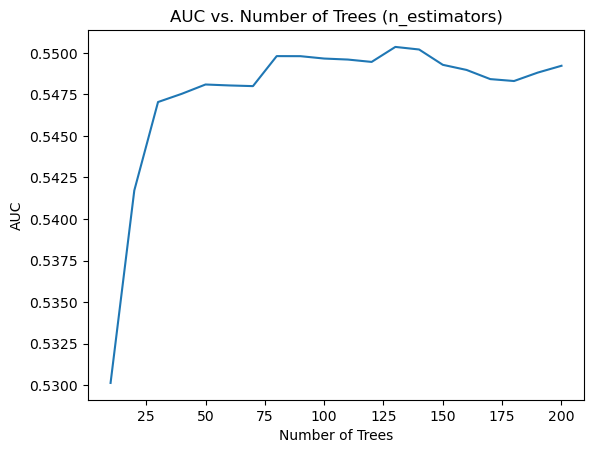

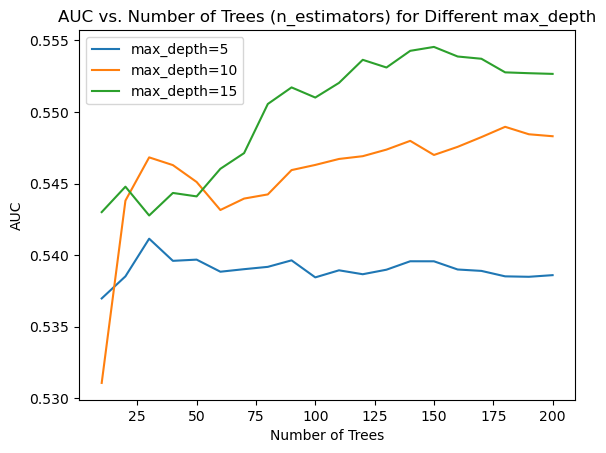

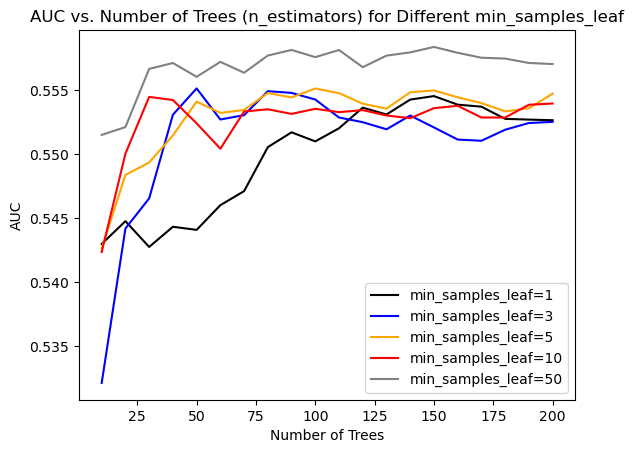

Random Forest Accuracy on the validation set: 0.5466666666666666
Random Forest Confusion Matrix on the validation set:
[[2896 1929]
 [2321 2229]]
Random Forest Classification Report on the validation set:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58      4825
           1       0.54      0.49      0.51      4550

    accuracy                           0.55      9375
   macro avg       0.55      0.55      0.54      9375
weighted avg       0.55      0.55      0.55      9375

Random Forest F1-Score on the validation set: 0.5119430408819476
Random Forest ROC-AUC on the validation set: 0.5570460171952399


In [20]:
# tuning estimators
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.title('AUC vs. Number of Trees (n_estimators)')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.show()

# best estimator
best_n_estimators = df_scores.loc[df_scores['auc'].idxmax(), 'n_estimators']

# tuning max_depth
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f'max_depth={d}')

plt.legend()
plt.title('AUC vs. Number of Trees (n_estimators) for Different max_depth')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.show()

# best max_depth
best_max_depth = df_scores.loc[df_scores['auc'].idxmax(), 'max_depth']

# tuning min_samples_leaf
scores = []
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=best_max_depth, min_samples_leaf=s, random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, color=col, label=f'min_samples_leaf={s}')

plt.legend()
plt.title('AUC vs. Number of Trees (n_estimators) for Different min_samples_leaf')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.show()

# best min_samples_leaf
best_min_samples_leaf = df_scores.loc[df_scores['auc'].idxmax(), 'min_samples_leaf']

# final model with best hyperparametern
rf = RandomForestClassifier(n_estimators=200, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
rf.fit(X_train, y_train)

# pred on val set
y_pred_val_rf = rf.predict(X_val)

# metrics
print(f"Random Forest Accuracy on the validation set: {accuracy_score(y_val, y_pred_val_rf)}")
print(f"Random Forest Confusion Matrix on the validation set:\n{confusion_matrix(y_val, y_pred_val_rf)}")
print(f"Random Forest Classification Report on the validation set:\n{classification_report(y_val, y_pred_val_rf)}")
print(f"Random Forest F1-Score on the validation set: {f1_score(y_val, y_pred_val_rf)}")
print(f"Random Forest ROC-AUC on the validation set: {roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])}")

## 3.5 XGBoost

Best Hyperparameters:
eta                  0.050000
max_depth           10.000000
min_child_weight     5.000000
auc                  0.589601
Name: 16, dtype: float64



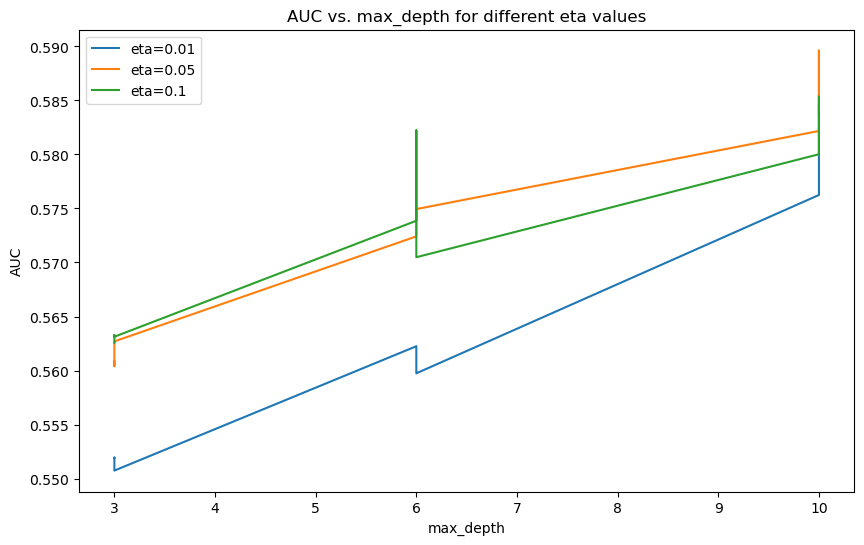

XGBoost Accuracy on the Validation Set: 0.5225066195939982
XGBoost Confusion Matrix on the Validation Set:
[[ 701 3972]
 [ 356 4035]]
XGBoost Classification Report on the Validation Set:
              precision    recall  f1-score   support

           0       0.66      0.15      0.24      4673
           1       0.50      0.92      0.65      4391

    accuracy                           0.52      9064
   macro avg       0.58      0.53      0.45      9064
weighted avg       0.59      0.52      0.44      9064

XGBoost F1-Score on the Validation Set: 0.6509114373286013
XGBoost ROC-AUC on the Validation Set: 0.5896007450213685


In [17]:
# define hyperparameter values to be tested
# learning rates
eta_values = [0.01, 0.05, 0.1]
# max depths of trees
max_depth_values = [3, 6, 10]
# min child weights
min_child_weight_values = [1, 5, 10]

# list to store results
scores = []

# loop through all combinations of the hyperparameters
for eta in eta_values:
    for max_depth in max_depth_values:
        for min_child_weight in min_child_weight_values:
            # define xgboost parameters
            xgb_params = {
                'eta': eta,
                'max_depth': max_depth,
                'min_child_weight': min_child_weight,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'scale_pos_weight': 2,  # for imbalanced datasets
                'nthread': 8,
                'seed': 1,
                'verbosity': 1,
            }

            # train model
            model_xgb = xgb.XGBClassifier(**xgb_params)
            model_xgb.fit(X_train, y_train)

            # predictions on validation
            y_pred_val_xgb = model_xgb.predict(X_val)

            # auc score
            auc = roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:, 1])

            # store results
            scores.append((eta, max_depth, min_child_weight, auc))

# convert results to df
df_scores = pd.DataFrame(scores, columns=['eta', 'max_depth', 'min_child_weight', 'auc'])

# display best combination of parameters
best_params = df_scores.loc[df_scores['auc'].idxmax()]
print(f"Best Hyperparameters:\n{best_params}\n")

# Plot auc scores for different hyperparameter combinations
fig, ax = plt.subplots(figsize=(10, 6))
for eta in eta_values:
    df_subset = df_scores[df_scores['eta'] == eta]
    ax.plot(df_subset['max_depth'], df_subset['auc'], label=f'eta={eta}')

ax.set_title('AUC vs. max_depth for different eta values')
ax.set_xlabel('max_depth')
ax.set_ylabel('AUC')
ax.legend()
plt.show()

# final model with best hyperparameters
best_eta = float(best_params['eta'])  # ensure eta is float
best_max_depth = int(best_params['max_depth'])  # ensure max_depth is int
best_min_child_weight = int(best_params['min_child_weight'])  # ensure min_child_weight is int


model_xgb_final = xgb.XGBClassifier(
    eta=best_eta,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=2,
    nthread=8,
    seed=1,
    verbosity=1
)

# Train final model
model_xgb_final.fit(X_train, y_train)

# make predictions and evaluate the final model
y_pred_val_xgb_final = model_xgb_final.predict(X_val)

print(f"XGBoost Accuracy on the Validation Set: {accuracy_score(y_val, y_pred_val_xgb_final)}")
print(f"XGBoost Confusion Matrix on the Validation Set:\n{confusion_matrix(y_val, y_pred_val_xgb_final)}")
print(f"XGBoost Classification Report on the Validation Set:\n{classification_report(y_val, y_pred_val_xgb_final)}")
print(f"XGBoost F1-Score on the Validation Set: {f1_score(y_val, y_pred_val_xgb_final)}")
print(f"XGBoost ROC-AUC on the Validation Set: {roc_auc_score(y_val, model_xgb_final.predict_proba(X_val)[:, 1])}")

In [27]:
# print all the features for json testfile
print(dv.get_feature_names_out())

['30d_ma' '7d_ma' '7d_volatility' 'adx' 'aroon' 'atr' 'bop' 'cci' 'close'
 'cmo' 'day' 'fibonacci_0' 'fibonacci_100' 'fibonacci_23_6'
 'fibonacci_38_2' 'fibonacci_50' 'fibonacci_61_8' 'growth_168h'
 'growth_24h' 'growth_336h' 'growth_48h' 'growth_4h' 'growth_720h'
 'growth_72h' 'high' 'hour' 'intraday_range' 'kama' 'low' 'macd'
 'macd_hist' 'macd_signal' 'mom' 'month' 'open' 'ppo' 'price_change' 'roc'
 'rsi' 'ticker=AAL' 'ticker=AAPL' 'ticker=ABEV' 'ticker=ABT' 'ticker=ADBE'
 'ticker=AGNC' 'ticker=ALV' 'ticker=AMD' 'ticker=AMGN' 'ticker=AMZN'
 'ticker=AVGO' 'ticker=BA' 'ticker=BAC' 'ticker=BAK' 'ticker=BBD'
 'ticker=BHP' 'ticker=BKKT' 'ticker=BLK' 'ticker=BMY' 'ticker=BNBUSDT'
 'ticker=BP' 'ticker=BTCUSDT' 'ticker=CAN' 'ticker=CAT' 'ticker=CCL'
 'ticker=CMCSA' 'ticker=CME' 'ticker=CMG' 'ticker=COIN' 'ticker=COST'
 'ticker=CRM' 'ticker=CSCO' 'ticker=CVX' 'ticker=DHR' 'ticker=DIS'
 'ticker=DJT' 'ticker=DOCN' 'ticker=DOGEUSDT' 'ticker=DTE' 'ticker=EBON'
 'ticker=ERIC' 'ticker=ETHUSDT' 'ti

In [34]:
# Save the besst model
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model_xgb_final, file)

#save features and parameter
with open('features.pkl', 'wb') as file:
    pickle.dump((X_train, X_val, y_train, y_val), file)

In [ ]:
# Model Comparison Summary:
# - XGBoost performed the best with the highest F1-score (0.64) and ROC-AUC (0.594).
# - It achieved a good balance between precision and recall for class 1, especially handling imbalanced data.
# - Random Forest was second-best but had a lower F1-score (0.51) and ROC-AUC (0.557).
# - Decision Tree and Logistic Regression underperformed due to simpler structures and inability to model complex patterns.
# - XGBoost is recommended for final deployment with potential improvements via feature engineering and Bayesian optimization.
